### Info:
- c1 is the gate voltage, c2- output voltage and c3- current.

### Todo:
- [x] Solve f such that f(c1, c3) = c2
- [x] Differentiate between expt, ideal, model
- [x] Differentiate between panasonic, transform, GaNsystems (use scalar parameters)
- [ ] Solve f such that f(c1, c2) = c3
- [ ] Solve f such that f(c1) = c2, c3  (multiple ouputs)
- [ ] Test meta-learning? - train on data from 2 devices, test on third?
    - Can also perform one-shot learning with ideal/model data to finally predict the expt data

In [1]:
import os
import glob
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dropout
from keras import backend as K

np.set_printoptions(suppress=True)

/home/saurabh/anaconda2/envs/pandagrader/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Reading all data

In [3]:
base_dir = '../../../Nikki/data'
data_dirs = [f'{base_dir}/data_02_03_18', f'{base_dir}/data_01_12_18']
fig_dir = './plots'

expt_static_params = {
    'transphorm': {'lg': 3.75, 'ld': 3.7, 'ls': 1.29},
    'panasonic': {'lg': 2.82, 'ld': 1.67, 'ls': 0.895},
    'gansystems': {'lg': 1, 'ld': 0.5, 'ls': 0.6},
}
non_expt_static_params = {
    'transphorm': {'lg': 2.8, 'ld': 2.06, 'ls': 1.04},
    'panasonic': {'lg': 3, 'ld': 1, 'ls': 1},
    'gansystems': {'lg': 0.8, 'ld': 0.4, 'ls': 0.5},
}
static_params = {
    'expt': expt_static_params,
    'model': non_expt_static_params,
    'ideal': non_expt_static_params
}
    
def read_data(data_dir):
    def is_it_c1_c2_or_c3(filename):
        return filename.split(' ')[-1].split('.')[0]
    
    dir_structures = list(os.walk(f'{data_dir}'))
    data_dicts = []
    for dirpath, dirnames, filenames in dir_structures[1:]:
        data_dict = {}
        data_dict['dir'] = dirpath
        for filename in filenames:
            data = is_it_c1_c2_or_c3(filename)
            data_dict[f'{data}_file'] = f'{filename}'
        device_name, data_type = dirpath.split('/')[-1].strip().split()
        data_dict['device_name'] = device_name.lower()
        data_dict['graph_type'] = data_type.lower()
        data_dict['date'] = '-'.join(data_dir.split('_')[-3:])
        data_dict['static_params'] = static_params[data_dict['graph_type']][data_dict['device_name']]
        data_dicts.append(data_dict)
    return data_dicts

df = pd.DataFrame(read_data(data_dirs[0]) + read_data(data_dirs[1]))
df

,c1_file,c2_file,c3_file,date,device_name,dir,graph_type,static_params
0,panasonic ideal gate voltage c1.txt,panasonic ideal switching voltage c2.txt,panasonic ideal current c3.txt,02-03-18,panasonic,../../../Nikki/data/data_02_03_18/Panasonic ideal,ideal,"{'lg': 3, 'ld': 1, 'ls': 1}"
1,transphorm ideal gate voltage c1.txt,transphorm ideal voltage c2.txt,Transphorm ideal current c3.txt,02-03-18,transphorm,../../../Nikki/data/data_02_03_18/Transphorm i...,ideal,"{'lg': 2.8, 'ld': 2.06, 'ls': 1.04}"
2,GaNsystems ideal gate voltage c1.txt,GaNSystems ideal switching voltage c2.txt,GaNsystems ideal current c3.txt,02-03-18,gansystems,../../../Nikki/data/data_02_03_18/Gansystems i...,ideal,"{'lg': 0.8, 'ld': 0.4, 'ls': 0.5}"
3,panasonic gate voltage c1.txt,panasonic model voltage c2.txt,panasonic model current c3.txt,02-03-18,panasonic,../../../Nikki/data/data_02_03_18/Panasonic model,model,"{'lg': 3, 'ld': 1, 'ls': 1}"
4,transphorm expt gate voltage c1.txt,transphorm expt voltage c2.txt,Transphorm expt current c3.txt,02-03-18,transphorm,../../../Nikki/data/data_02_03_18/Transphorm expt,expt,"{'lg': 3.75, 'ld': 3.7, 'ls': 1.29}"
5,GaNsystems model gate voltage c1.txt,GaNSystems model switching voltage c2.txt,GaNsystems model current c3.txt,02-03-18,gansystems,../../../Nikki/data/data_02_03_18/Gansystems m...,model,"{'lg': 0.8, 'ld': 0.4, 'ls': 0.5}"
6,GaNsystems expt gate voltage c1.txt,GaNSystems expt switching voltage c2.txt,GaNsystems expt current c3.txt,02-03-18,gansystems,../../../Nikki/data/data_02_03_18/Gansystems expt,expt,"{'lg': 1, 'ld': 0.5, 'ls': 0.6}"
7,transphorm model gate voltage c1.txt,transphorm model voltage c2.txt,Transphorm model current c3.txt,02-03-18,transphorm,../../../Nikki/data/data_02_03_18/Transphorm m...,model,"{'lg': 2.8, 'ld': 2.06, 'ls': 1.04}"
8,panasonic expt gate voltage c1.txt,panasonic expt voltage c2.txt,panasonic expt current c3.txt,02-03-18,panasonic,../../../Nikki/data/data_02_03_18/Panasonic expt,expt,"{'lg': 2.82, 'ld': 1.67, 'ls': 0.895}"
9,panasonic ideal gate voltage c1.txt,panasonic ideal switching voltage c2.txt,panasonic ideal current c3.txt,01-12-18,panasonic,../../../Nikki/data/data_01_12_18/Panasonic ideal,ideal,"{'lg': 3, 'ld': 1, 'ls': 1}"


In [4]:
def read_datafile(filename):
    time, cx = zip(*[
        list(map(float, line.strip().split('\t'))) 
        for line in open(filename, 'r')
    ])
    return [t * 1e09 for t in time], list(cx)

df['c1'] = [read_datafile(f'{row.dir}/{row.c1_file}')[1] for _, row in df.iterrows()]
df['c2'] = [read_datafile(f'{row.dir}/{row.c2_file}')[1] for _, row in df.iterrows()]
df['c3'] = [read_datafile(f'{row.dir}/{row.c3_file}')[1] for _, row in df.iterrows()]
df['len'] = [len(row.c1) for _, row in df.iterrows()]
del df['dir']
df

,c1_file,c2_file,c3_file,date,device_name,graph_type,static_params,c1,c2,c3,len
0,panasonic ideal gate voltage c1.txt,panasonic ideal switching voltage c2.txt,panasonic ideal current c3.txt,02-03-18,panasonic,ideal,"{'lg': 3, 'ld': 1, 'ls': 1}","[3.1375, 3.1375, 3.1375, 3.1375, 3.1375, 3.137...","[4.12497, 4.12497, 4.12497, 4.12497, 4.12497, ...","[20.5625, 20.5625, 20.5625, 20.5625, 20.5625, ...",1002
1,transphorm ideal gate voltage c1.txt,transphorm ideal voltage c2.txt,Transphorm ideal current c3.txt,02-03-18,transphorm,ideal,"{'lg': 2.8, 'ld': 2.06, 'ls': 1.04}","[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, ...","[3.12497, 3.12497, 3.12497, 3.12497, -3.05e-05...","[20.5625, 20.5625, 20.875, 20.875, 21.1875, 20...",1002
2,GaNsystems ideal gate voltage c1.txt,GaNSystems ideal switching voltage c2.txt,GaNsystems ideal current c3.txt,02-03-18,gansystems,ideal,"{'lg': 0.8, 'ld': 0.4, 'ls': 0.5}","[6.00123, 6.00123, 6.00123, 6.00123, 6.00123, ...","[3.12497, 3.12497, 3.12497, 3.12497, 3.12497, ...","[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15....",1002
3,panasonic gate voltage c1.txt,panasonic model voltage c2.txt,panasonic model current c3.txt,02-03-18,panasonic,model,"{'lg': 3, 'ld': 1, 'ls': 1}","[3.4375, 3.28125, 3.4375, 3.28125, 3.4375, 3.4...","[4.12497, 3.59375, 3.59375, 3.4375, 3.4375, 3....","[20.25, 20.5625, 20.5625, 20.5625, 20.875, 20....",1002
4,transphorm expt gate voltage c1.txt,transphorm expt voltage c2.txt,Transphorm expt current c3.txt,02-03-18,transphorm,expt,"{'lg': 3.75, 'ld': 3.7, 'ls': 1.29}","[7.4375, 7.125, 7.59375, 7.4375, 7.28125, 7.28...","[7.5, 4.375, 7.5, 4.375, 4.375, 4.375, 10.625,...","[20.5625, 20.5625, 20.875, 20.875, 21.1875, 20...",1002
5,GaNsystems model gate voltage c1.txt,GaNSystems model switching voltage c2.txt,GaNsystems model current c3.txt,02-03-18,gansystems,model,"{'lg': 0.8, 'ld': 0.4, 'ls': 0.5}","[5.90123, 5.90123, 5.90123, 5.90123, 5.90123, ...","[6.24997, 3.12497, -3.05e-05, -3.05e-05, 3.124...","[15.25, 15.25, 15.25, 15.25, 15.25, 15.25, 15....",1002
6,GaNsystems expt gate voltage c1.txt,GaNSystems expt switching voltage c2.txt,GaNsystems expt current c3.txt,02-03-18,gansystems,expt,"{'lg': 1, 'ld': 0.5, 'ls': 0.6}","[6.41563, 6.25625, 5.9375, 6.25625, 6.25625, 6...","[6.24997, 3.12497, -3.05e-05, -3.05e-05, 3.124...","[15.25, 15.5625, 15.5625, 15.875, 15.5625, 15....",1002
7,transphorm model gate voltage c1.txt,transphorm model voltage c2.txt,Transphorm model current c3.txt,02-03-18,transphorm,model,"{'lg': 2.8, 'ld': 2.06, 'ls': 1.04}","[8.4375, 8.125, 8.59375, 8.4375, 8.28125, 8.28...","[3.12497, 3.12497, 3.12497, 3.12497, -3.05e-05...","[20.25, 20.875, 20.5625, 20.875, 20.25, 20.875...",1002
8,panasonic expt gate voltage c1.txt,panasonic expt voltage c2.txt,panasonic expt current c3.txt,02-03-18,panasonic,expt,"{'lg': 2.82, 'ld': 1.67, 'ls': 0.895}","[3.4375, 3.125, 3.59375, 3.4375, 3.28125, 3.28...","[4.375, 1.25, 1.25, 7.5, 1.25, 1.25, -1.875, 4...","[20.5625, 20.5625, 20.875, 20.875, 21.1875, 20...",1002
9,panasonic ideal gate voltage c1.txt,panasonic ideal switching voltage c2.txt,panasonic ideal current c3.txt,01-12-18,panasonic,ideal,"{'lg': 3, 'ld': 1, 'ls': 1}","[3.1375, 3.1375, 3.1375, 3.1375, 3.1375, 3.137...","[4.12497, 4.12497, 4.12497, 4.12497, 4.12497, ...","[20.5625, 20.5625, 20.5625, 20.5625, 20.5625, ...",1002


## Ploting all data

In [5]:
def plot_data(c1, c2, c3, c1_pred=None, c2_pred=None, c3_pred=None, title=None, save=False):
    assert len(c1) == len(c2) == len(c3)
    plts = {}
    fig, ax1 = plt.subplots(1,1, figsize=(16, 8))
    if title:
        ax1.set_title(title)
    x = range(len(c1))

    plts['c2'] = ax1.plot(x, c2, c='b', label='c2/output voltage')
    if c2_pred is not None:
        plts['c2_pred'] = ax1.plot(x, c2_pred, c='k', label='c2 pred/output voltage')
    ax1.set_ylabel('Output voltage (Vds)', color='b')
    ax1.tick_params('y', colors='b')
    ax1.set_xlabel('time steps')

    ax2 = ax1.twinx()
    plts['c1'] = ax2.plot(x, c1, c='g', label='c1/gate voltage')
    plts['c3'] = ax2.plot(x, c3, c='r', label='c3/current')
    if c1_pred is not None:
        plts['c1_pred'] = ax2.plot(x, c1_pred, c='k', label='c1 pred/gate voltage')
    if c3_pred is not None:
        plts['c3_pred'] = ax2.plot(x, c3_pred, c='k', label='c3 pred/current')        
        
    ax2.set_ylabel('Gate voltage (Vgs) / Current (Ids)', color='r')
    ax2.tick_params('y', colors='r')

    plts_list = [plts[k][0] for k in sorted(list(plts.keys()))]
    labels = [l.get_label() for l in plts_list]
    ax1.legend(plts_list, labels, loc='upper right')
    if save and title:
        plt.savefig(f'{fig_dir}/{title}.png')

In [6]:
df.date.unique()

array(['02-03-18', '01-12-18'], dtype=object)

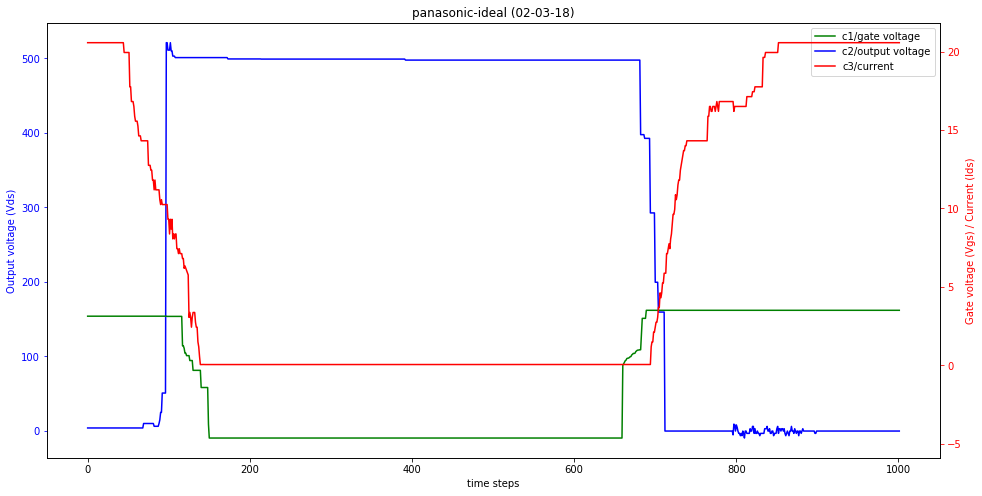

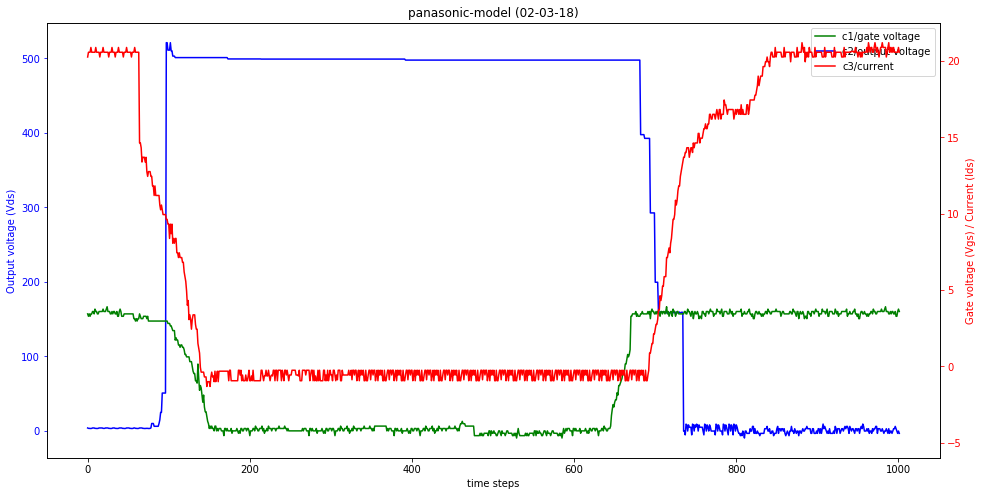

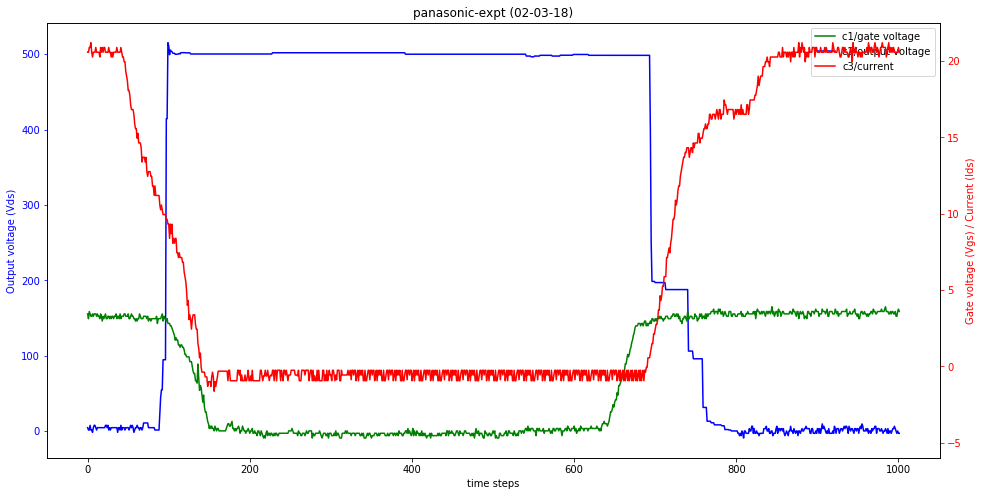

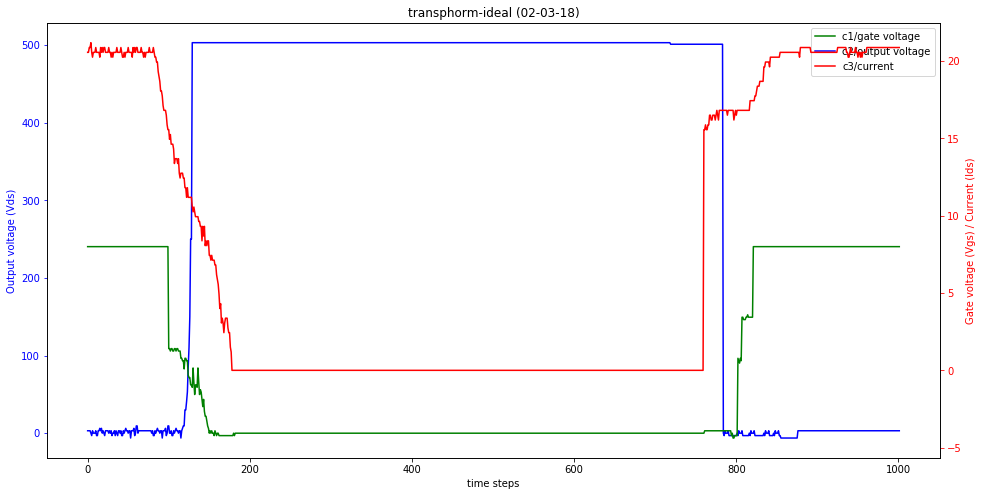

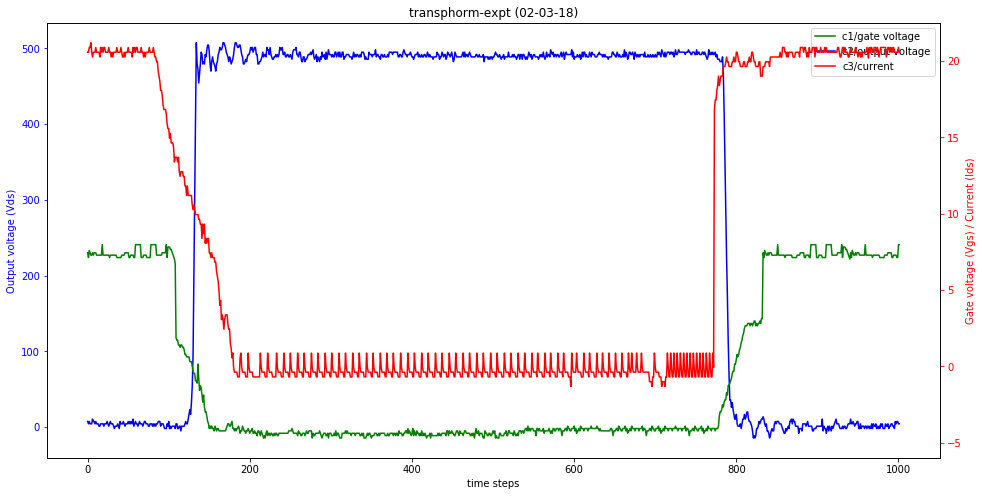

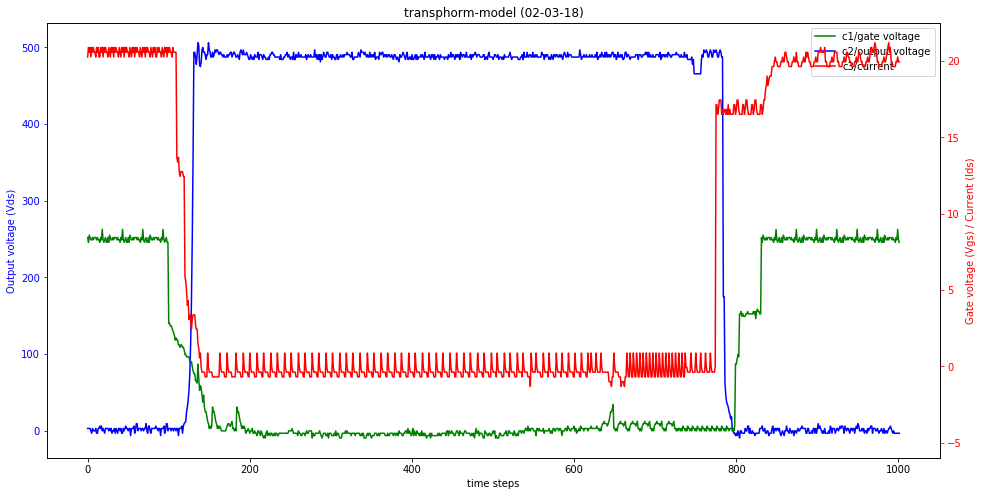

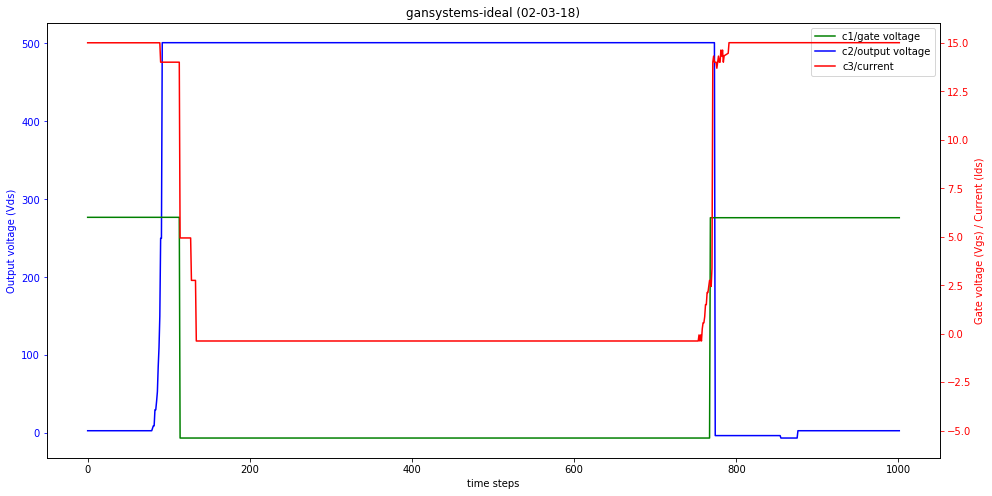

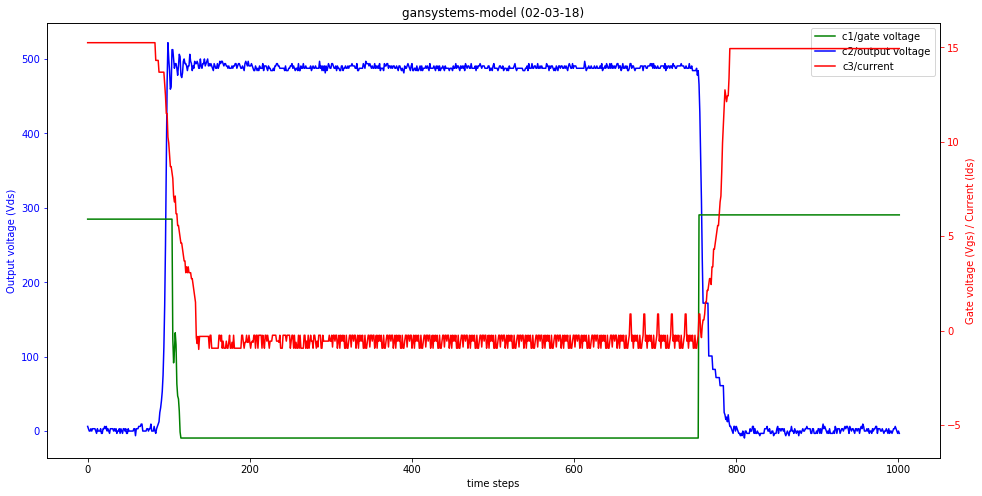

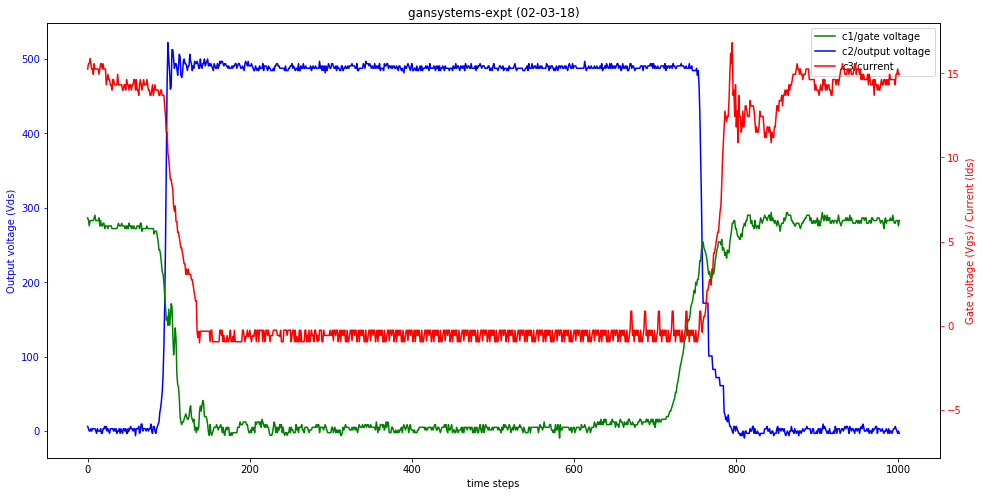

In [7]:
## So let's understand what's the difference between expt, model, ideal
def plot_all_graphs_on(date, save):
    for device_name in df.device_name.unique():
        plot_df = df[(df.device_name == device_name) & (df.date == date)]
        for _, row in plot_df.iterrows():
            plot_data(row.c1, row.c2, row.c3, title=f'{row.device_name}-{row.graph_type} ({row.date})', save=save)
            
plot_all_graphs_on(date='02-03-18', save=False)

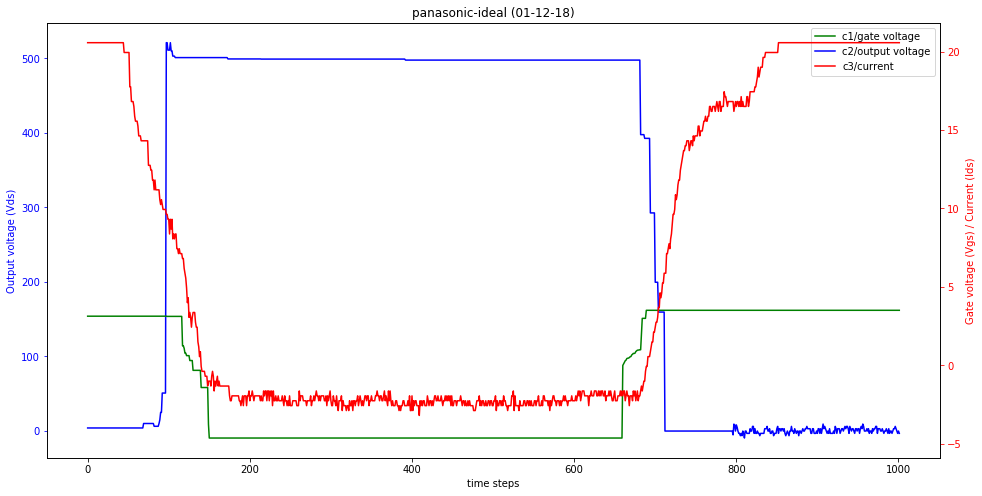

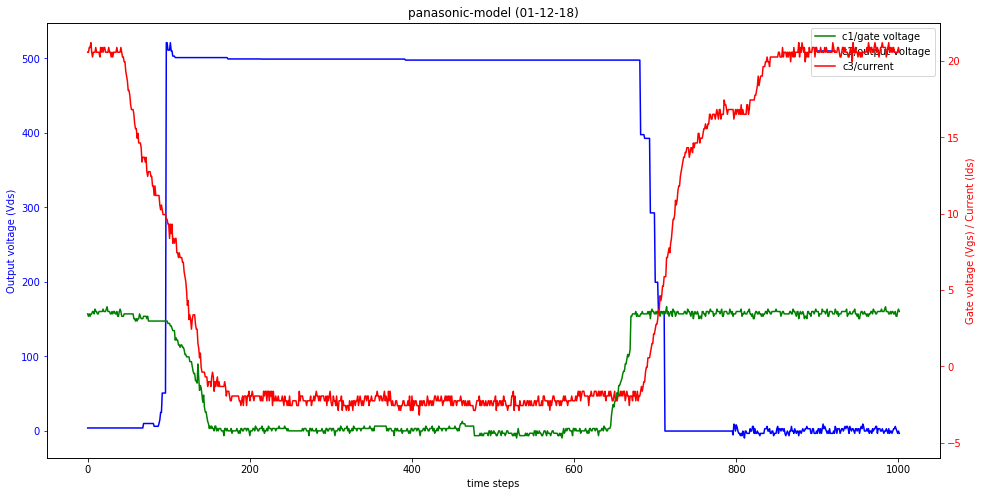

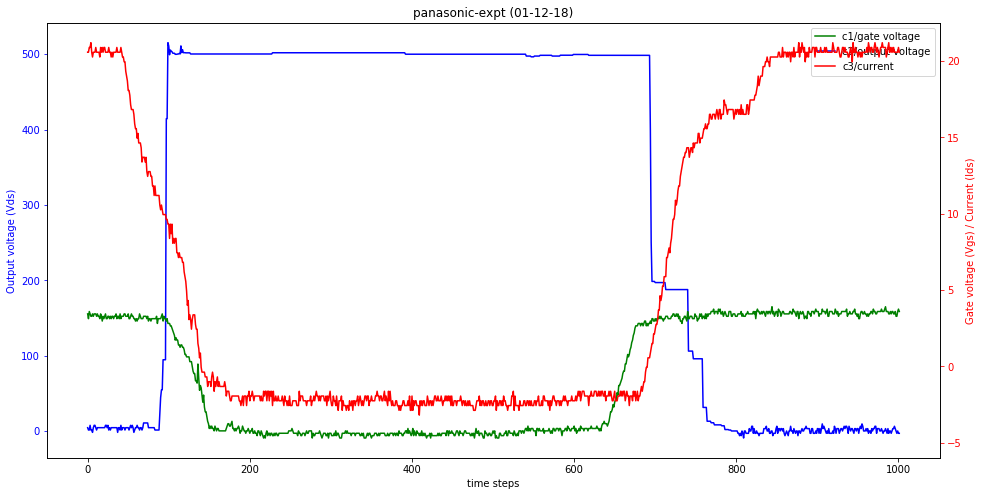

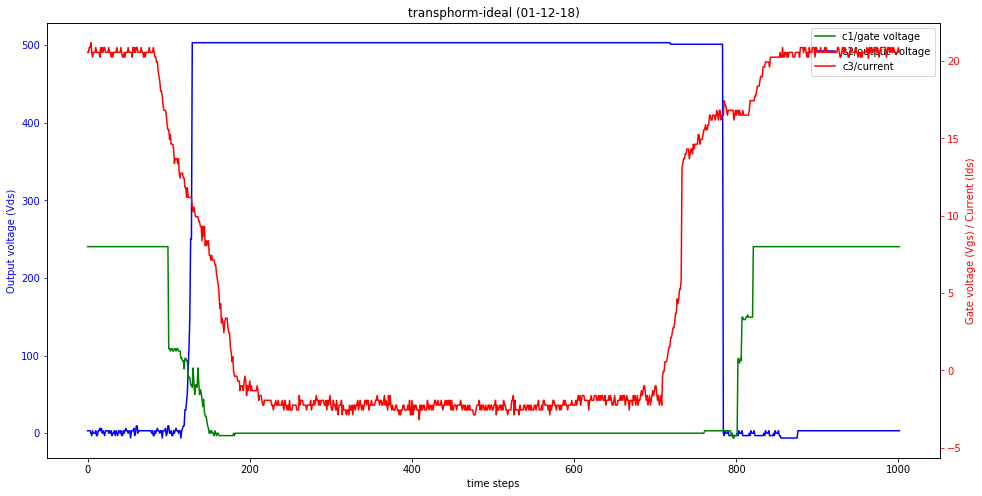

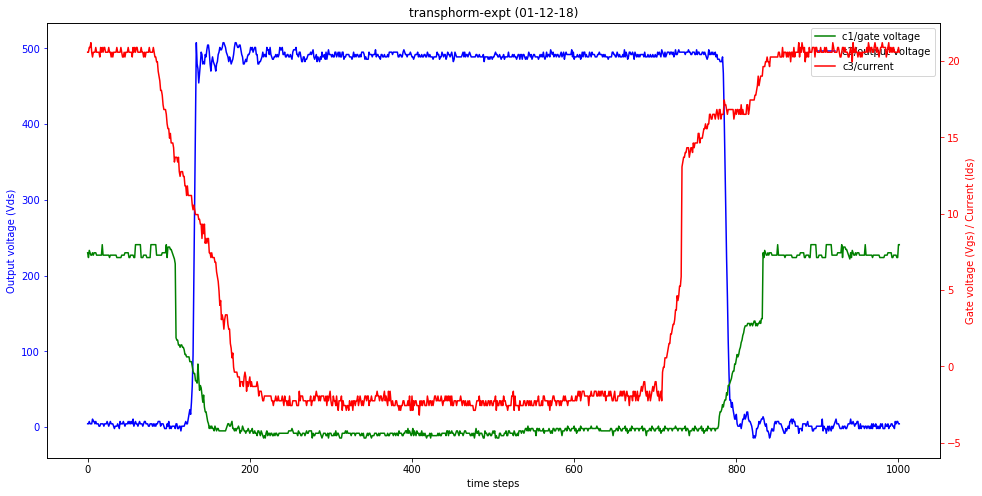

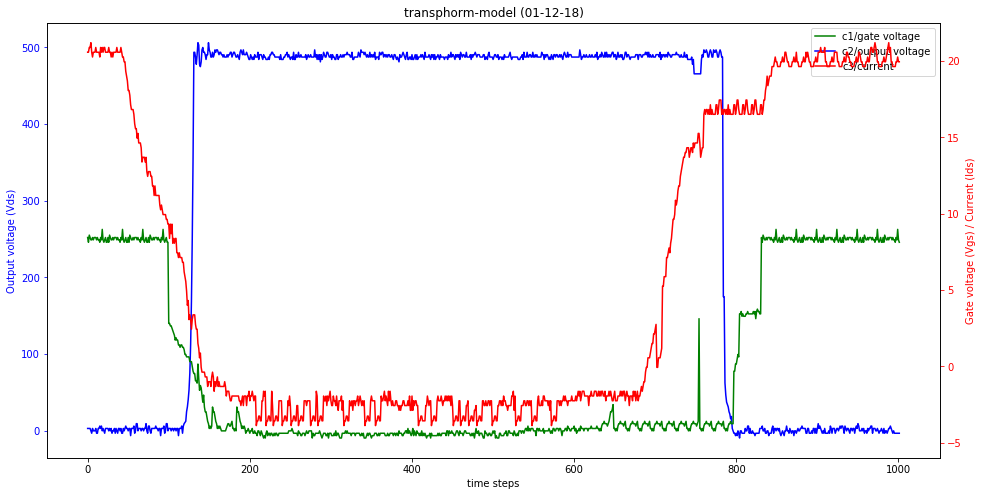

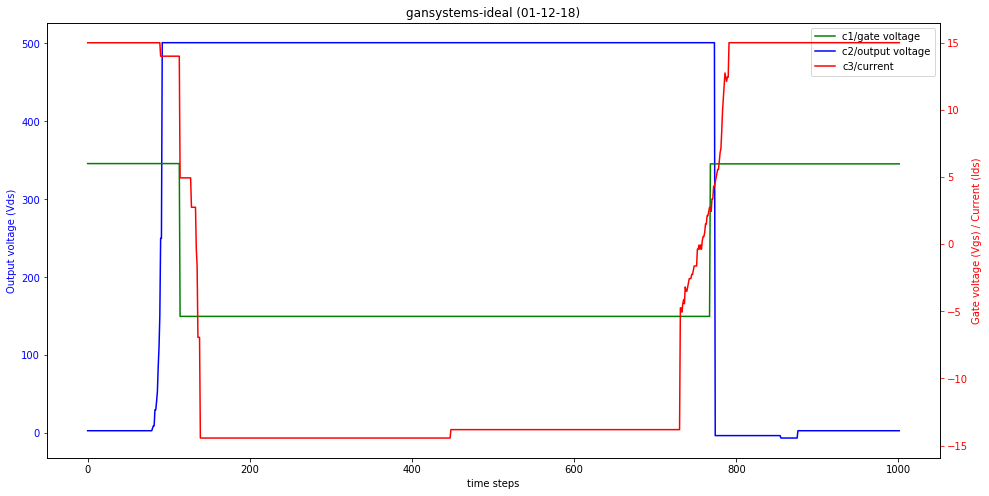

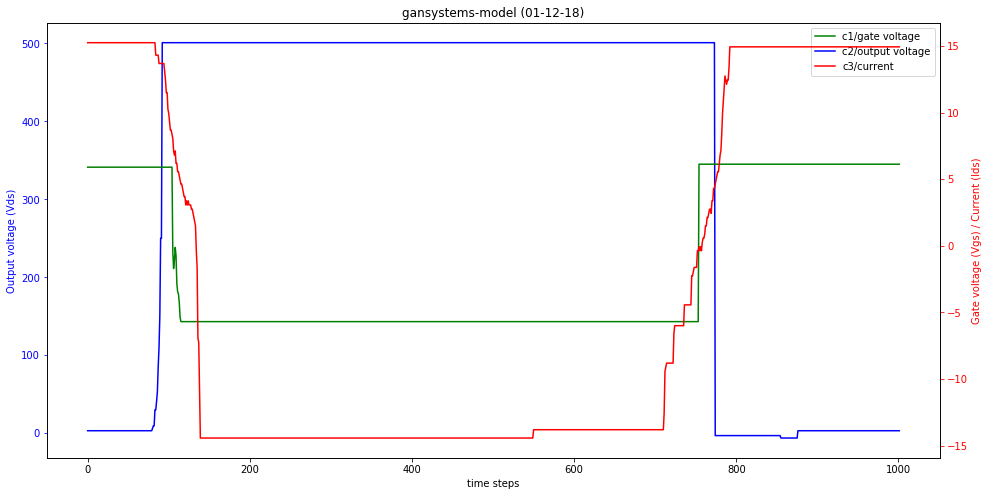

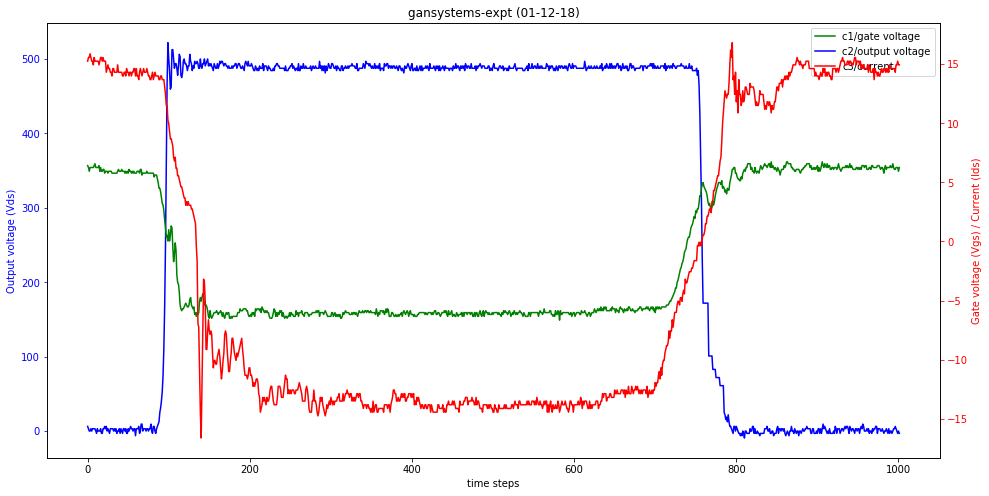

In [8]:
plot_all_graphs_on(date='01-12-18', save=False)

## Splitting data for training

 - Data info: 18 plots in total (**6 `expts`**, 6 `model`, 6 `ideal`)
 - We should `test` the model **only** on `expt` data as that is the final objective.
 - 2 logical ways to generate the `test` data:
     - **Approach [1]** - have 1 plot from each of the devices - implying the data for that device has been exposed to the model during training
     - **Approach [2]** - have 2 plots from a specific device - implying the data for that device has **not** been exposed to the model during training (this is a case of meta-learning)
 - Due to the limited data (especially `expt`), we decide not to have a `validation` data split

In [9]:
## Taking Approach 1 for test data 
# - have 1 plot from each of the devices 
# - implying the data for that device has been exposed to the model during training

test_date = '02-03-18'
test_df = df[(df.graph_type == 'expt') & (df.date == test_date)]
test_df

,c1_file,c2_file,c3_file,date,device_name,graph_type,static_params,c1,c2,c3,len
4,transphorm expt gate voltage c1.txt,transphorm expt voltage c2.txt,Transphorm expt current c3.txt,02-03-18,transphorm,expt,"{'lg': 3.75, 'ld': 3.7, 'ls': 1.29}","[7.4375, 7.125, 7.59375, 7.4375, 7.28125, 7.28...","[7.5, 4.375, 7.5, 4.375, 4.375, 4.375, 10.625,...","[20.5625, 20.5625, 20.875, 20.875, 21.1875, 20...",1002
6,GaNsystems expt gate voltage c1.txt,GaNSystems expt switching voltage c2.txt,GaNsystems expt current c3.txt,02-03-18,gansystems,expt,"{'lg': 1, 'ld': 0.5, 'ls': 0.6}","[6.41563, 6.25625, 5.9375, 6.25625, 6.25625, 6...","[6.24997, 3.12497, -3.05e-05, -3.05e-05, 3.124...","[15.25, 15.5625, 15.5625, 15.875, 15.5625, 15....",1002
8,panasonic expt gate voltage c1.txt,panasonic expt voltage c2.txt,panasonic expt current c3.txt,02-03-18,panasonic,expt,"{'lg': 2.82, 'ld': 1.67, 'ls': 0.895}","[3.4375, 3.125, 3.59375, 3.4375, 3.28125, 3.28...","[4.375, 1.25, 1.25, 7.5, 1.25, 1.25, -1.875, 4...","[20.5625, 20.5625, 20.875, 20.875, 21.1875, 20...",1002


In [10]:
train_df = df.copy()
train_df.drop(test_df.index, inplace=True)
train_df

,c1_file,c2_file,c3_file,date,device_name,graph_type,static_params,c1,c2,c3,len
0,panasonic ideal gate voltage c1.txt,panasonic ideal switching voltage c2.txt,panasonic ideal current c3.txt,02-03-18,panasonic,ideal,"{'lg': 3, 'ld': 1, 'ls': 1}","[3.1375, 3.1375, 3.1375, 3.1375, 3.1375, 3.137...","[4.12497, 4.12497, 4.12497, 4.12497, 4.12497, ...","[20.5625, 20.5625, 20.5625, 20.5625, 20.5625, ...",1002
1,transphorm ideal gate voltage c1.txt,transphorm ideal voltage c2.txt,Transphorm ideal current c3.txt,02-03-18,transphorm,ideal,"{'lg': 2.8, 'ld': 2.06, 'ls': 1.04}","[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, ...","[3.12497, 3.12497, 3.12497, 3.12497, -3.05e-05...","[20.5625, 20.5625, 20.875, 20.875, 21.1875, 20...",1002
2,GaNsystems ideal gate voltage c1.txt,GaNSystems ideal switching voltage c2.txt,GaNsystems ideal current c3.txt,02-03-18,gansystems,ideal,"{'lg': 0.8, 'ld': 0.4, 'ls': 0.5}","[6.00123, 6.00123, 6.00123, 6.00123, 6.00123, ...","[3.12497, 3.12497, 3.12497, 3.12497, 3.12497, ...","[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15....",1002
3,panasonic gate voltage c1.txt,panasonic model voltage c2.txt,panasonic model current c3.txt,02-03-18,panasonic,model,"{'lg': 3, 'ld': 1, 'ls': 1}","[3.4375, 3.28125, 3.4375, 3.28125, 3.4375, 3.4...","[4.12497, 3.59375, 3.59375, 3.4375, 3.4375, 3....","[20.25, 20.5625, 20.5625, 20.5625, 20.875, 20....",1002
5,GaNsystems model gate voltage c1.txt,GaNSystems model switching voltage c2.txt,GaNsystems model current c3.txt,02-03-18,gansystems,model,"{'lg': 0.8, 'ld': 0.4, 'ls': 0.5}","[5.90123, 5.90123, 5.90123, 5.90123, 5.90123, ...","[6.24997, 3.12497, -3.05e-05, -3.05e-05, 3.124...","[15.25, 15.25, 15.25, 15.25, 15.25, 15.25, 15....",1002
7,transphorm model gate voltage c1.txt,transphorm model voltage c2.txt,Transphorm model current c3.txt,02-03-18,transphorm,model,"{'lg': 2.8, 'ld': 2.06, 'ls': 1.04}","[8.4375, 8.125, 8.59375, 8.4375, 8.28125, 8.28...","[3.12497, 3.12497, 3.12497, 3.12497, -3.05e-05...","[20.25, 20.875, 20.5625, 20.875, 20.25, 20.875...",1002
9,panasonic ideal gate voltage c1.txt,panasonic ideal switching voltage c2.txt,panasonic ideal current c3.txt,01-12-18,panasonic,ideal,"{'lg': 3, 'ld': 1, 'ls': 1}","[3.1375, 3.1375, 3.1375, 3.1375, 3.1375, 3.137...","[4.12497, 4.12497, 4.12497, 4.12497, 4.12497, ...","[20.5625, 20.5625, 20.5625, 20.5625, 20.5625, ...",1002
10,transphorm ideal gate voltage c1.txt,transphorm ideal voltage c2.txt,Transphorm ideal current c3.txt,01-12-18,transphorm,ideal,"{'lg': 2.8, 'ld': 2.06, 'ls': 1.04}","[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, ...","[3.12497, 3.12497, 3.12497, 3.12497, -3.05e-05...","[20.5625, 20.5625, 20.875, 20.875, 21.1875, 20...",1002
11,GaNsystems ideal gate voltage c1.txt,GaNSystems ideal switching voltage c2.txt,GaNsystems ideal current c3.txt,01-12-18,gansystems,ideal,"{'lg': 0.8, 'ld': 0.4, 'ls': 0.5}","[6.00123, 6.00123, 6.00123, 6.00123, 6.00123, ...","[3.12497, 3.12497, 3.12497, 3.12497, 3.12497, ...","[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15....",1002
12,panasonic gate voltage c1.txt,panasonic model voltage c2.txt,panasonic model current c3.txt,01-12-18,panasonic,model,"{'lg': 3, 'ld': 1, 'ls': 1}","[3.4375, 3.28125, 3.4375, 3.28125, 3.4375, 3.4...","[4.12497, 4.12497, 4.12497, 4.12497, 4.12497, ...","[20.5625, 20.5625, 20.875, 20.875, 21.1875, 20...",1002


# Experiments

In [11]:
def generate_model_data(df, inputs, output, use_static_params=False):
    def generate_input_for_row(row, inputs, use_static_params):
        if not use_static_params:
            return np.stack([row[inputs[0]], row[inputs[1]]], axis=-1)
        static_params = list(row.static_params.values())
        static_params = np.array([static_params for _ in range(row.len)])
        input0 = np.expand_dims(row[inputs[0]], axis=-1)
        input1 = np.expand_dims(row[inputs[1]], axis=-1)
        return np.concatenate([input0, input1, static_params], axis=-1)
    
    x = np.stack([generate_input_for_row(row, inputs, use_static_params) for _, row in df.iterrows()], axis=0)
    y = np.expand_dims(np.stack(df[output].tolist(), axis=0), axis=-1)
    return x, y

def standardize_features(x, mean=None, std=None):
    if mean is None:
        mean, std = np.mean(x, axis=(0, 1)), np.std(x, axis=(0, 1))
    return (x - mean) / std, mean, std


## Model 1: f(c1, c3) = c2

In [36]:
x_train, y_train = generate_model_data(train_df, inputs=['c1', 'c3'], output='c2', use_static_params=True)
x_test, y_test = generate_model_data(test_df, inputs=['c1', 'c3'], output='c2', use_static_params=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((15, 1002, 5), (15, 1002, 1), (3, 1002, 5), (3, 1002, 1))

In [37]:
# If all lengths are not same - use keras.preprocessing.sequence.pad_sequences() to pad to largest size as:
# x_train = np.array(sequence.pad_sequences(x_train, maxlen=max_time_sequence, dtype=np.float64))
assert len(df.len.unique()) == 1

In [38]:
x_train, x_mean, x_std = standardize_features(x_train)
x_test, _, _ = standardize_features(x_test, x_mean, x_std)

y_train, y_mean, y_std = standardize_features(y_train)
y_test, _, _ = standardize_features(y_test, y_mean, y_std)

In [39]:
np.savez('models/mean-std-params_input-c1-c3_output-c2_test-approach1_staticp.npz', x_mean=x_mean, x_std=x_std, y_mean=y_mean, y_std=y_std)

In [44]:
max_time_sequence = x_train.shape[1]
max_time_sequence

1002

### Model def

In [49]:
# input : (batch_size, max_time_sequence, input_dim)
model = Sequential()
nodes = [32, 32]
# model.add(GRU(64, return_sequences=True, input_shape=(max_time_sequence, 2)))
# model.add(LSTM(nodes[0], return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(max_time_sequence, 2)))
# model.add(LSTM(nodes[1], return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model.add(LSTM(nodes[0], return_sequences=True, input_shape=x_train.shape[1:]))
model.add(LSTM(nodes[1], return_sequences=True))
model.add(Dense(1, kernel_initializer='normal'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1002, 32)          4864      
_________________________________________________________________
lstm_4 (LSTM)                (None, 1002, 32)          8320      
_________________________________________________________________
dense_2 (Dense)              (None, 1002, 1)           33        
Total params: 13,217
Trainable params: 13,217
Non-trainable params: 0
_________________________________________________________________


In [50]:
opt = Adam(lr=0.001)  # default: 0.001
model.compile(loss='mean_squared_error', optimizer=opt)

In [51]:
time = datetime.now().strftime('%Y%m%d%H%M')
nodes_str = '_'.join(map(str, nodes))
filename = f"_models/gan-{nodes_str}-{time}-" + "epoch_{epoch:02d}-val_loss_{val_loss:.2f}.h5"
model_saver = ModelCheckpoint(filepath=filename, monitor='val_loss', save_best_only=True)

history = model.fit(x_train, y_train, 
                    batch_size=8,
                    shuffle=True,
                    epochs=500, 
                    validation_data=(x_test, y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=20), model_saver])

Train on 15 samples, validate on 3 samples
Epoch 1/500
15/15 [==============================] - 5s 317ms/step - loss: 0.9209 - val_loss: 0.8888
Epoch 2/500
15/15 [==============================] - 3s 217ms/step - loss: 0.8810 - val_loss: 0.8504
Epoch 3/500
15/15 [==============================] - 3s 217ms/step - loss: 0.8325 - val_loss: 0.8067
Epoch 4/500
15/15 [==============================] - 3s 227ms/step - loss: 0.7790 - val_loss: 0.7572
Epoch 5/500
15/15 [==============================] - 3s 222ms/step - loss: 0.7169 - val_loss: 0.6994
Epoch 6/500
15/15 [==============================] - 3s 218ms/step - loss: 0.6485 - val_loss: 0.6325
Epoch 7/500
15/15 [==============================] - 3s 217ms/step - loss: 0.5737 - val_loss: 0.5564
Epoch 8/500
15/15 [==============================] - 3s 219ms/step - loss: 0.4979 - val_loss: 0.4740
Epoch 9/500
15/15 [==============================] - 3s 218ms/step - loss: 0.4245 - val_loss: 0.3908
Epoch 10/500
15/15 [============================

Epoch 81/500
15/15 [==============================] - 3s 230ms/step - loss: 0.0466 - val_loss: 0.0201
Epoch 82/500
15/15 [==============================] - 4s 246ms/step - loss: 0.0436 - val_loss: 0.0211
Epoch 83/500
15/15 [==============================] - 4s 242ms/step - loss: 0.0421 - val_loss: 0.0222
Epoch 84/500
15/15 [==============================] - 3s 232ms/step - loss: 0.0427 - val_loss: 0.0235
Epoch 85/500
15/15 [==============================] - 3s 223ms/step - loss: 0.0422 - val_loss: 0.0213
Epoch 86/500
15/15 [==============================] - 3s 226ms/step - loss: 0.0435 - val_loss: 0.0214
Epoch 87/500
15/15 [==============================] - 3s 225ms/step - loss: 0.0436 - val_loss: 0.0208
Epoch 88/500
15/15 [==============================] - 3s 226ms/step - loss: 0.0436 - val_loss: 0.0209
Epoch 89/500
15/15 [==============================] - 3s 228ms/step - loss: 0.0432 - val_loss: 0.0209
Epoch 90/500
15/15 [==============================] - 3s 227ms/step - loss: 0.0414

In [52]:
best_model = !ls -t _models | head -n 1
best_model[0]

'gan-32_32-201802251929-epoch_102-val_loss_0.02.h5'

In [61]:
!cp _models/gan-32_32-201802251929-epoch_102-val_loss_0.02.h5 models/

In [53]:
model.load_weights(f'_models/{best_model[0]}')

In [54]:
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

### The below cell is a method to evaluate the model
 - Our objective is to come up with a model which does better than the `ideal` data and maybe even better than the `model` data
 - Hence, the below 2 cells pits the `prediction_error` against the `ideal_error` and `model_error`
 - The lower the `error` the better
 - `ideal_error = mean_squared_error(expt_data, ideal_data)`
 - `model_error = mean_squared_error(expt_data, model_data)`

In [12]:
def plot_loss(list1, label1, list2=None, label2=None, title='Plot'):
    plt.figure()
    plt.title(title)
    plt.plot(list1, 'r', label=label1)
    if list2 is not None and list2 is not []:
        plt.plot(list2, 'b', label=label2)
    plt.legend()
    plt.savefig(f'{fig_dir}/{title}.png')

def mean_squared_error(y_true, y_pred):
    # assumes first dimension is batch_size
    mean_axis = tuple(range(1, np.ndim(y_true)))
    return np.mean(np.square(y_pred - y_true), axis=mean_axis)

def get_loss(row, df, input_data, mean, std):
    expt_df = df[(df.device_name == row.device_name) & (df.date == row.date) & (df.graph_type == 'expt')]
    y_true = (np.array(expt_df[input_data].tolist()) - mean) / std
    y_pred = (np.array(row[input_data]) - mean) / std
    return mean_squared_error(y_true, y_pred)[0]    

def compare_errors(y_test, y_test_pred, loss_type, test_df, df):
    date = test_df.date.unique()[0]
    pred_errors = mean_squared_error(y_test, y_test_pred)

    for pred_error, (_, row) in zip(pred_errors, test_df.iterrows()):
        _df = df[(df.date == date) & (df.device_name == row.device_name)]
        try:
            ideal_error = _df[df.graph_type == 'ideal'][loss_type].tolist()[0]
        except:
            ideal_error = np.nan
        model_error = _df[df.graph_type == 'model'][loss_type].tolist()[0]
        print(f'For {row.device_name}: prediction_error = {pred_error}, ideal_error = {ideal_error}, model_error = {model_error}')

In [56]:
loss_type = 'c2_loss'
df[loss_type] = [
    get_loss(row, df, 'c2', y_mean, y_std)
    if row.graph_type != 'expt' else 0
    for _, row in df.iterrows()
]

compare_errors(y_test, y_test_pred, loss_type, test_df, df)

For transphorm: prediction_error = 0.020982737633469015, ideal_error = 0.02657474075975711, model_error = 0.012041490771542622
For gansystems: prediction_error = 0.012567815668085586, ideal_error = 0.05888835319621217, model_error = 4.968316995855836e-06
For panasonic: prediction_error = 0.018548293389229094, ideal_error = 0.026096969917323624, model_error = 0.011259930029712744


/home/saurabh/anaconda2/envs/pandagrader/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/saurabh/anaconda2/envs/pandagrader/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


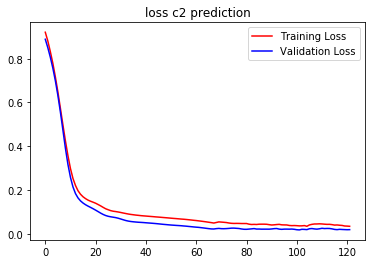

In [58]:
plot_loss(history.history['loss'], 'Training Loss', history.history['val_loss'], 'Validation Loss', 'loss c2 prediction')

## Results

- with model" `gan-32_32-201802251929-epoch_102-val_loss_0.02.h5`
```
For transphorm: prediction_error = 0.020982737633469015, ideal_error = 0.02657474075975711, model_error = 0.012041490771542622
For gansystems: prediction_error = 0.012567815668085586, ideal_error = 0.05888835319621217, model_error = 4.968316995855836e-06
For panasonic: prediction_error = 0.018548293389229094, ideal_error = 0.026096969917323624, model_error = 0.011259930029712744
```

- with model: `gan-32_32-201802181741-epoch_104-val_loss_0.02.h5`
```
For transphorm: prediction_error = 0.008630567763397894, ideal_error = 0.02668760720465228, model_error = 0.012092632578226972
For gansystems: prediction_error = 0.020634671257184982, ideal_error = 0.05913845983435681, model_error = 4.989418096389726e-06
For panasonic: prediction_error = 0.02625170960829904, ideal_error = nan, model_error = 0.01130775244437753
```

- with model: `gan-201802172204-epoch_298-val_loss_0.02.h5` (had `[64] GRU nodes`)
```
For transphorm: prediction_error = 0.018219443779639112, ideal_error = 0.02668760720465228, model_error = 0.012092632578226972
For gansystems: prediction_error = 0.022094997912845405, ideal_error = 0.05913845983435681, model_error = 4.989418096389726e-06
For panasonic: prediction_error = 0.019040101893601502, ideal_error = nan, model_error = 0.01130775244437753
```

- with model: `gan-32_32-201802172236-epoch_130-val_loss_0.02.h5` (had `[32, 32] LSTM nodes`)
```
For transphorm: prediction_error = 0.01055438163755651, ideal_error = 0.02668760720465228, model_error = 0.012092632578226972
For gansystems: prediction_error = 0.015530452864580928, ideal_error = 0.05913845983435681, model_error = 4.989418096389726e-06
For panasonic: prediction_error = 0.029289353524128075, ideal_error = nan, model_error = 0.01130775244437753
```

In [13]:
def plot_prediction(x, y, y_pred, title=None, save=False):
    x = (x * x_std) + x_mean
    y = (y * y_std) + y_mean
    y_pred = (y_pred * y_std) + y_mean  # c2
    plot_data(c1=x[:,0], c2=y.ravel(), c3=x[:,1], c1_pred=None, c2_pred=y_pred.ravel(), c3_pred=None, title=title, save=save)

### Plotting prediction on test data (`expt`)

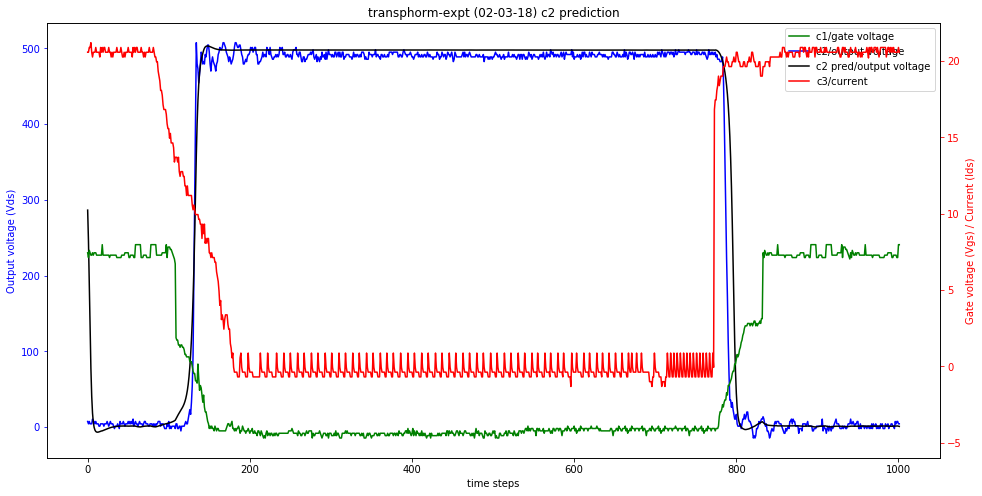

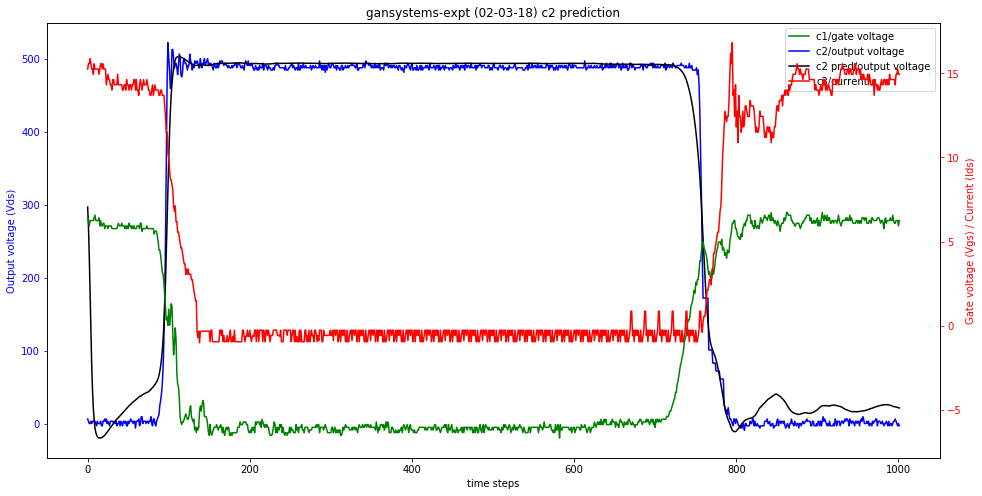

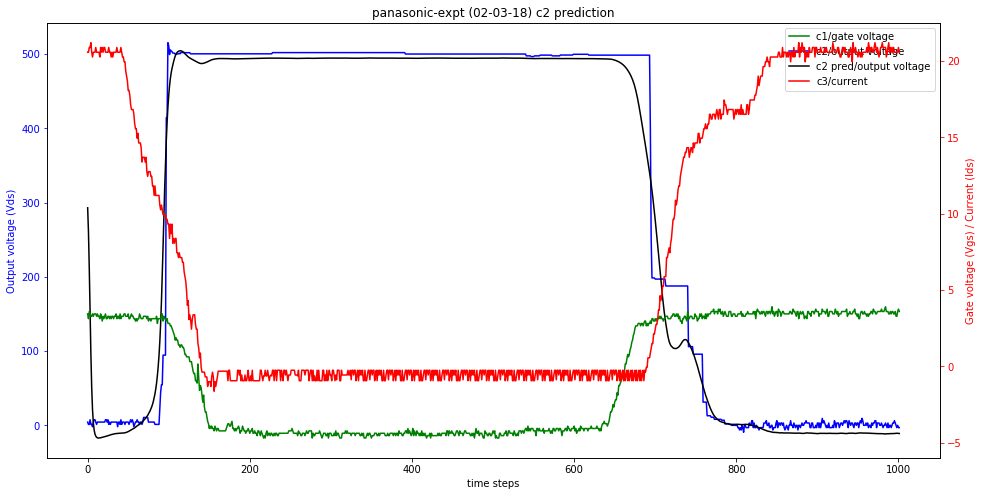

In [60]:
for i in range(x_test.shape[0]):
    row = test_df.iloc[i]
    figname = f'{row.device_name}-{row.graph_type} ({row.date}) c2 prediction'
    plot_prediction(x_test[i], y_test[i], y_test_pred[i], title=figname, save=False)

## Model 2: f(c1, c2) = c3

In [14]:
x_train, y_train = generate_model_data(train_df, inputs=['c1', 'c2'], output='c3', use_static_params=True)
x_test, y_test = generate_model_data(test_df, inputs=['c1', 'c2'], output='c3', use_static_params=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((15, 1002, 5), (15, 1002, 1), (3, 1002, 5), (3, 1002, 1))

In [18]:
x_train, x_mean, x_std = standardize_features(x_train)
x_test, _, _ = standardize_features(x_test, x_mean, x_std)

y_train, y_mean, y_std = standardize_features(y_train)
y_test, _, _ = standardize_features(y_test, y_mean, y_std)

In [117]:
np.savez('models/mean-std-params_input-c1-c2_output-c3_test-approach1_staticp.npz', x_mean=x_mean, x_std=x_std, y_mean=y_mean, y_std=y_std)

In [19]:
time_sequence = x_train.shape[1]

### Model def

In [42]:
# input : (batch_size, max_time_sequence, input_dim)
model = Sequential()
nodes = [32, 32, 32]
# model.add(GRU(64, return_sequences=True, input_shape=(max_time_sequence, 2)))
# model.add(LSTM(nodes[0], return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=x_train.shape[1:]))
# model.add(LSTM(nodes[1], return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
# model.add(LSTM(nodes[2], return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model.add(LSTM(nodes[0], return_sequences=True, input_shape=x_train.shape[1:]))
model.add(LSTM(nodes[1], return_sequences=True))
model.add(LSTM(nodes[2], return_sequences=True))
model.add(Dense(1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 1002, 32)          4864      
_________________________________________________________________
lstm_7 (LSTM)                (None, 1002, 32)          8320      
_________________________________________________________________
lstm_8 (LSTM)                (None, 1002, 32)          8320      
_________________________________________________________________
dense_3 (Dense)              (None, 1002, 1)           33        
Total params: 21,537
Trainable params: 21,537
Non-trainable params: 0
_________________________________________________________________


In [43]:
opt = Adam(lr=0.0001)  # default: 0.001
model.compile(loss='mean_squared_error', optimizer=opt)

In [44]:
time = datetime.now().strftime('%Y%m%d%H%M')
nodes_str = '_'.join(map(str, nodes))
filename = f"_models/gan-c3_pred-{nodes_str}-{time}-" + "epoch_{epoch:02d}-val_loss_{val_loss:.4f}.h5"
model_saver = ModelCheckpoint(filepath=filename, monitor='val_loss', save_best_only=True)

history = model.fit(x_train, y_train, 
                    batch_size=8,
                    shuffle=True,
                    epochs=1500, 
                    validation_data=(x_test, y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=100), model_saver])

Train on 15 samples, validate on 3 samples
Epoch 1/1500
15/15 [==============================] - 7s 466ms/step - loss: 0.9185 - val_loss: 0.6129
Epoch 2/1500
15/15 [==============================] - 6s 391ms/step - loss: 0.9045 - val_loss: 0.6033
Epoch 3/1500
15/15 [==============================] - 6s 379ms/step - loss: 0.8920 - val_loss: 0.5936
Epoch 4/1500
15/15 [==============================] - 6s 378ms/step - loss: 0.8783 - val_loss: 0.5836
Epoch 5/1500
15/15 [==============================] - 6s 375ms/step - loss: 0.8644 - val_loss: 0.5735
Epoch 6/1500
15/15 [==============================] - 6s 371ms/step - loss: 0.8498 - val_loss: 0.5633
Epoch 7/1500
15/15 [==============================] - 6s 378ms/step - loss: 0.8357 - val_loss: 0.5531
Epoch 8/1500
15/15 [==============================] - 6s 386ms/step - loss: 0.8215 - val_loss: 0.5429
Epoch 9/1500
15/15 [==============================] - 6s 382ms/step - loss: 0.8066 - val_loss: 0.5327
Epoch 10/1500
15/15 [==================

15/15 [==============================] - 5s 365ms/step - loss: 0.1768 - val_loss: 0.1600
Epoch 81/1500
15/15 [==============================] - 6s 376ms/step - loss: 0.1769 - val_loss: 0.1590
Epoch 82/1500
15/15 [==============================] - 6s 385ms/step - loss: 0.1767 - val_loss: 0.1583
Epoch 83/1500
15/15 [==============================] - 5s 356ms/step - loss: 0.1763 - val_loss: 0.1583
Epoch 84/1500
15/15 [==============================] - 6s 386ms/step - loss: 0.1761 - val_loss: 0.1584
Epoch 85/1500
15/15 [==============================] - 5s 361ms/step - loss: 0.1763 - val_loss: 0.1587
Epoch 86/1500
15/15 [==============================] - 5s 355ms/step - loss: 0.1758 - val_loss: 0.1581
Epoch 87/1500
15/15 [==============================] - 5s 350ms/step - loss: 0.1758 - val_loss: 0.1575
Epoch 88/1500
15/15 [==============================] - 5s 356ms/step - loss: 0.1755 - val_loss: 0.1572
Epoch 89/1500
15/15 [==============================] - 5s 356ms/step - loss: 0.1754 - v

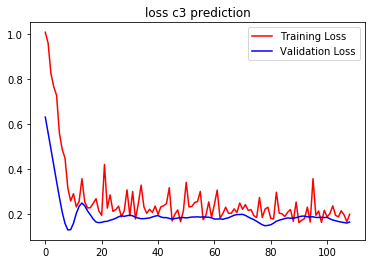

In [33]:
plot_loss(history.history['loss'], 'Training Loss', 
          history.history['val_loss'], 'Validation Loss', 'loss c3 prediction')    

In [34]:
best_model = !ls -t _models | head -n 1
best_model[0]

'gan-c3_pred-32_32_32-201802252240-epoch_09-val_loss_0.1282.h5'

In [38]:
model.load_weights(f'_models/{best_model[0]}')

In [26]:
K.get_value(model.optimizer.lr)

0.001

In [39]:
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

### The below cell is a method to evaluate the model
 - Our objective is to come up with a model which does better than the `ideal` data and maybe even better than the `model` data
 - Hence, the below 2 cells pits the `prediction_error` against the `ideal_error` and `model_error`
 - The lower the `error` the better
 - `ideal_error = mean_squared_error(expt_data, ideal_data)`
 - `model_error = mean_squared_error(expt_data, model_data)`

In [40]:
loss_type = 'c3_loss'
df['c3_loss'] = [
    get_loss(row, df, 'c3', y_mean, y_std)
    if row.graph_type != 'expt' else 0
    for _, row in df.iterrows()
]

compare_errors(y_test, y_test_pred, loss_type, test_df, df)

For transphorm: prediction_error = 0.20989518590387177, ideal_error = 0.03392678373633122, model_error = 0.04101885429654381
For gansystems: prediction_error = 0.09981351625913715, ideal_error = 0.019761319981005342, model_error = 0.005938601546112904
For panasonic: prediction_error = 0.07497843604947305, ideal_error = 0.0027283148928945525, model_error = 0.003232503675367707


/home/saurabh/anaconda2/envs/pandagrader/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/saurabh/anaconda2/envs/pandagrader/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


## Results

- with model: `gan-c3_pred-64_64-201802182013-epoch_50-val_loss_0.09.h5`
```
For transphorm: prediction_error = 0.16167914107258552, ideal_error = 0.03329356763051398, model_error = 0.040253270403163184
For gansystems: prediction_error = 0.03633400042308652, ideal_error = 0.019392490852331388, model_error = 0.005827762329102095
For panasonic: prediction_error = 0.07466878545118938, ideal_error = nan, model_error = 0.0031721715965811028
```

- with model: `gan-32_32-201802181903-epoch_42-val_loss_0.11.h5`
```
For transphorm: prediction_error = 0.17824583887744233, ideal_error = 0.03329356763051398, model_error = 0.040253270403163184
For gansystems: prediction_error = 0.08003233255423499, ideal_error = 0.019392490852331388, model_error = 0.005827762329102095
For panasonic: prediction_error = 0.07988175598975399, ideal_error = nan, model_error = 0.0031721715965811028
```

### Plotting prediction on test data (`expt`)

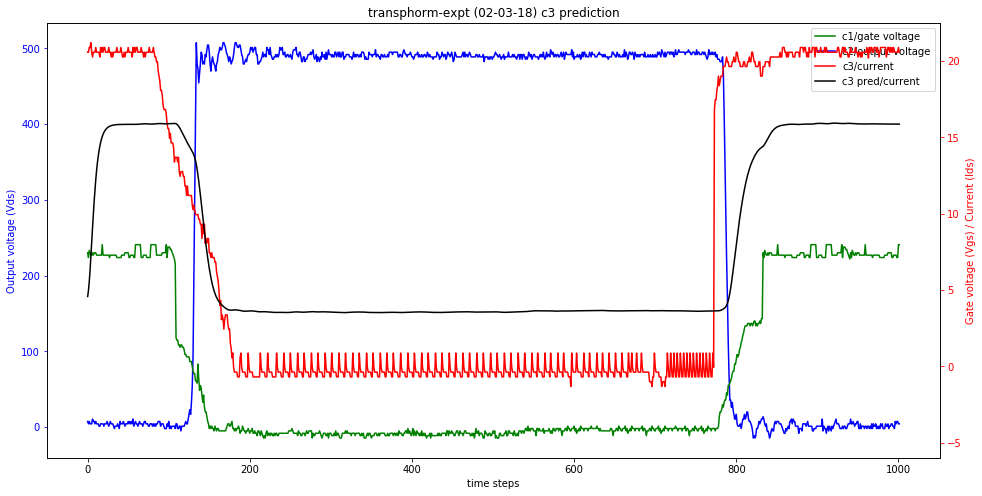

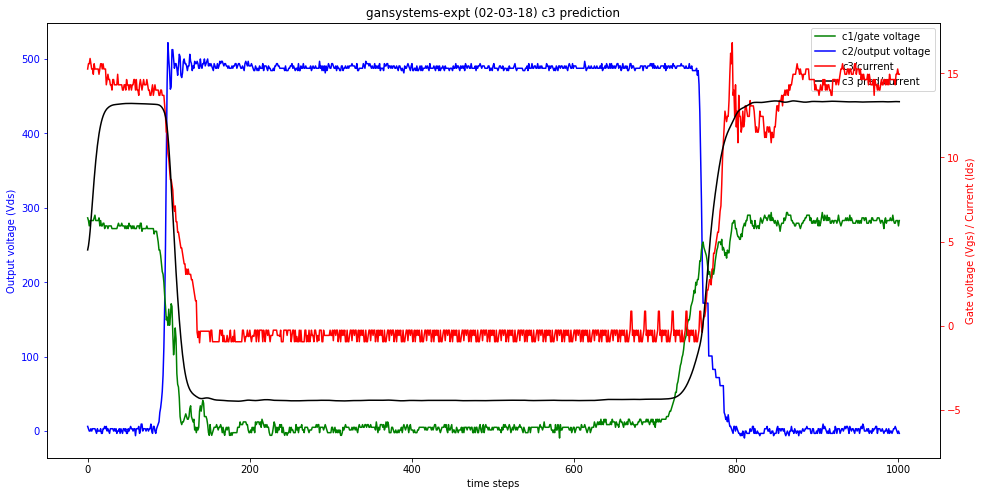

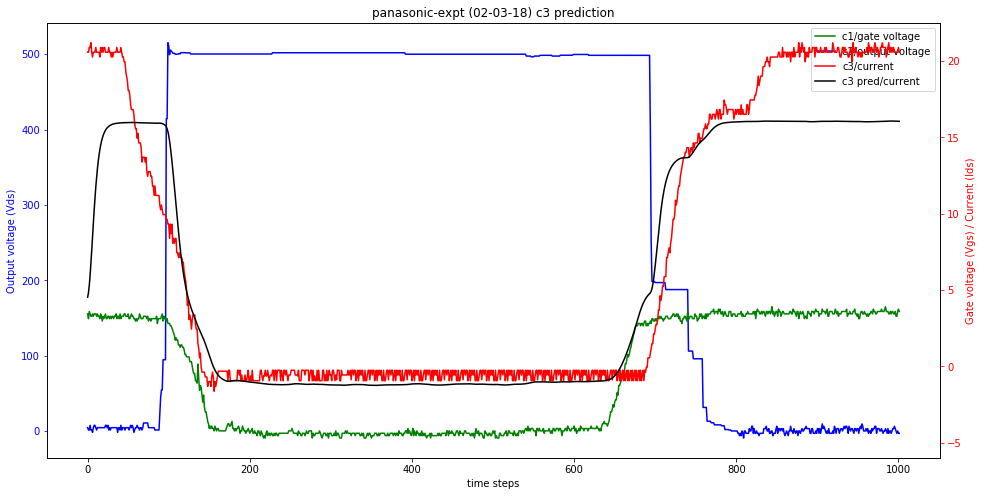

In [41]:
pad_length = 0
def plot_prediction(x, y, y_pred, title=None, save=False):
    x = (x * x_std) + x_mean
    y = (y * y_std) + y_mean
    y_pred = (y_pred * y_std) + y_mean  # c3
    plot_data(c1=x[pad_length:,0], c3=y[pad_length:].ravel(), c2=x[pad_length:,1], 
              c1_pred=None, c3_pred=y_pred[pad_length:].ravel(), c2_pred=None, title=title, save=save)

for i in range(x_test.shape[0]):
    row = test_df.iloc[i]
    figname = f'{row.device_name}-{row.graph_type} ({row.date}) c3 prediction'
    plot_prediction(x_test[i], y_test[i], y_test_pred[i], title=figname, save=False)

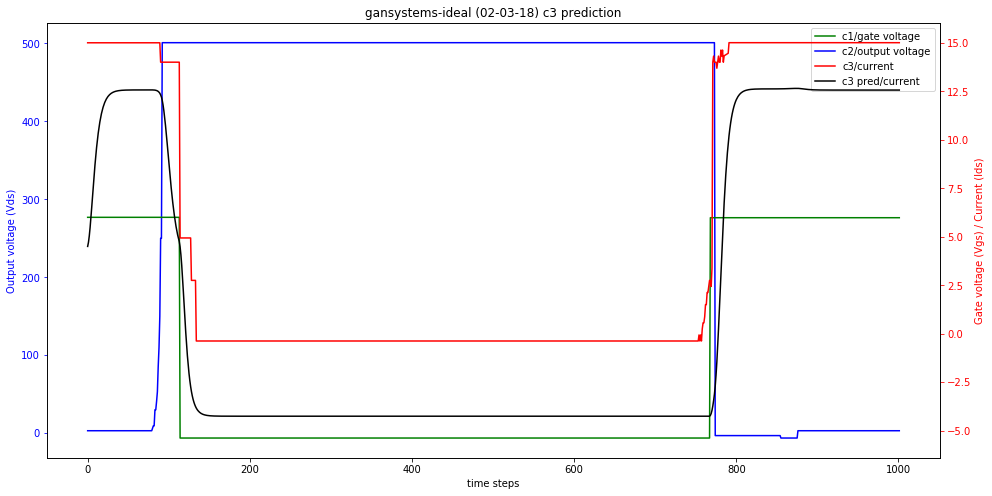

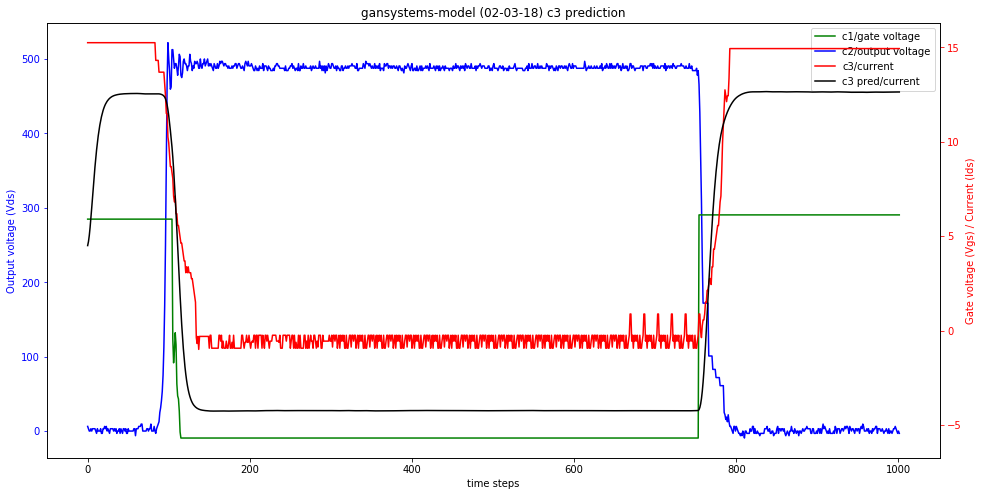

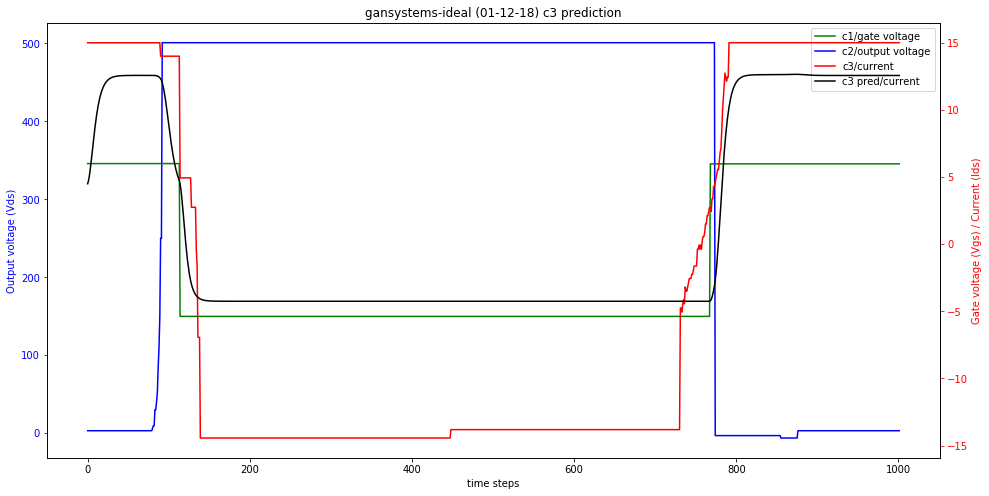

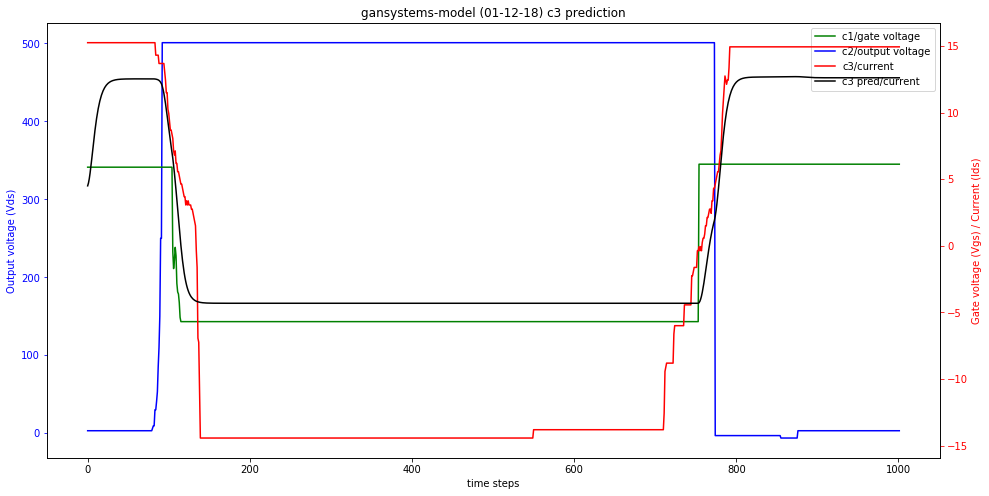

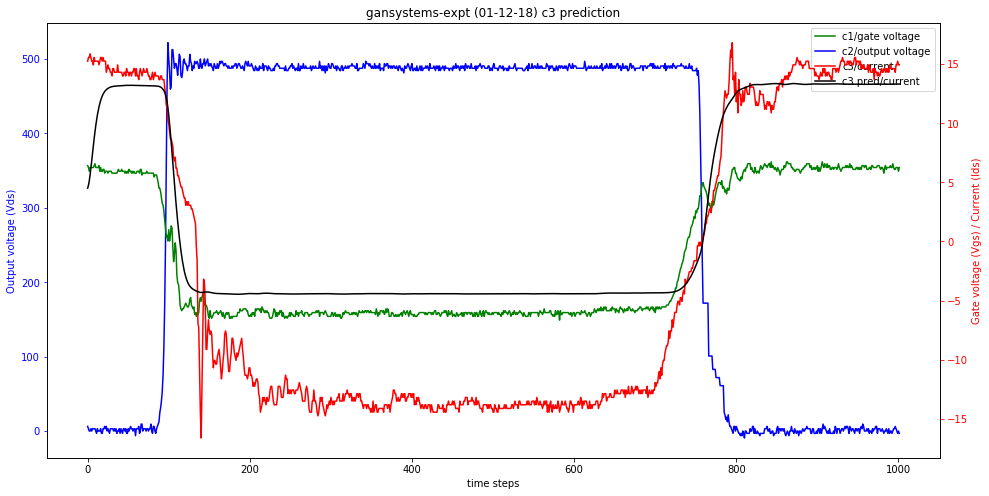

In [45]:
def plot_prediction1(x, y, y_pred, title=None, save=False):
    x = (x * x_std) + x_mean
    y = (y * y_std) + y_mean
    y_pred = (y_pred * y_std) + y_mean  # c3
    plot_data(c1=x[pad_length:,0], c3=y[pad_length:].ravel(), c2=x[pad_length:,1], 
              c1_pred=None, c3_pred=y_pred[pad_length:].ravel(), c2_pred=None, title=title, save=save)

    
for i in range(x_train.shape[0]):
    row = train_df.iloc[i]
    figname = f'{row.device_name}-{row.graph_type} ({row.date}) c3 prediction'
    if row.device_name == 'gansystems':
        plot_prediction1(x_train[i], y_train[i], y_train_pred[i], title=figname, save=False)
#     plot_data(c1=row.c1, c3=row.c3, c2=row.c2, c1_pred=None, 
#               c3_pred=y_train_pred[i][pad_length:].ravel(), c2_pred=None, title=None, save=False)    